In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
#the first data set that has 304 record 
data=pd.read_csv('heart1_304.csv')
df_1=pd.DataFrame(data)
print(df_1.shape)
df_1.head()


(303, 14)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
#Reprocessing on the data 
#df_1=df_1.drop(['caa','thall'], axis=1)
df_1=df_1.rename(columns = {'age':'Age', 'sex':'Sex','cp':'ChestPainType','trtbps':'RestingBP', 'chol':'Cholesterol','fbs':'FastingBS','restecg':'RestingECG', 'thalachh':'MaxHR','exng':'ExerciseAngina','oldpeak':'Oldpeak','slp':'ST_Slope','output':'Label'})
df_1 = pd.get_dummies(df_1, columns = ['ChestPainType', 'RestingECG','ST_Slope']) 
df_1=df_1.rename(columns = {'ChestPainType_0':'ChestPainType_TA', 'ChestPainType_1':'ChestPainType_ATA','ChestPainType_2':'ChestPainType_NAP','ChestPainType_3':'ChestPainType_ASY', 'RestingECG_0':'RestingECG_Normal','RestingECG_1':'RestingECG_ST','RestingECG_2':'RestingECG_LVH', 'ST_Slope_2':'ST_Slope_Down','ST_Slope_1':'ST_Slope_Flat','ST_Slope_0':'ST_Slope_Up'})
df_1.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,caa,thall,...,ChestPainType_TA,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_ASY,RestingECG_Normal,RestingECG_ST,RestingECG_LVH,ST_Slope_Up,ST_Slope_Flat,ST_Slope_Down
0,63,1,145,233,1,150,0,2.3,0,1,...,0,0,0,1,1,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,2,...,0,0,1,0,0,1,0,1,0,0
2,41,0,130,204,0,172,0,1.4,0,2,...,0,1,0,0,1,0,0,0,0,1
3,56,1,120,236,0,178,0,0.8,0,2,...,0,1,0,0,0,1,0,0,0,1
4,57,0,120,354,0,163,1,0.6,0,2,...,1,0,0,0,0,1,0,0,0,1


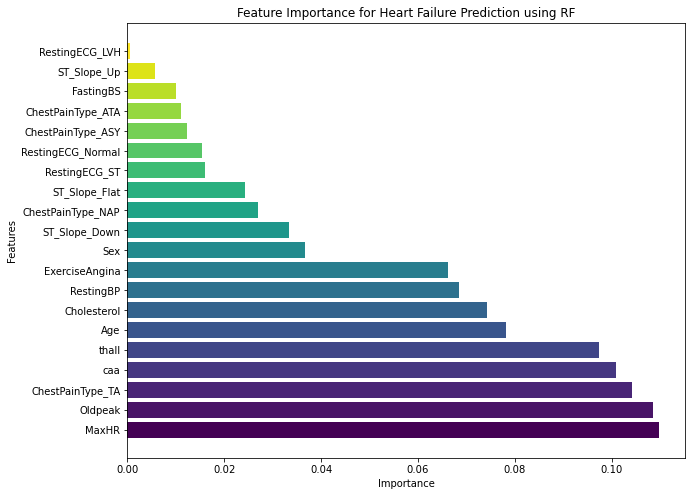

In [57]:
## Plot the Correlation between the Features and Label using RF
# Separate features and labels
X = df_1.drop('Label', axis=1)
y = df_1['Label']

# Set seeds for reproducibility
np.random.seed(42)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Get feature importances from the trained RF model
feature_importances = rf_model.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Define colors for each feature
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance_df)))

# Plot horizontal bar plot with different colors for each feature
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color=colors)
plt.title('Feature Importance for Heart Failure Prediction using RF')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


In [49]:
##Runing the MetaModel on the First data set 
# Load a dataset
X = df_1.drop('Label', axis=1)
y = df_1['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models and set the prameters 
base_models = [
    ('rf', RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42)),
    ('gb', XGBClassifier(n_estimators=25,max_depth=3)),
    ('svc', SVC(C=1.0, kernel='linear', gamma='scale', probability=True))
]

# Define meta-model
meta_model = KNeighborsClassifier(n_neighbors=10)

# Stacking 
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train stacked model
stacked_model.fit(X_train, y_train)

# Evaluate the model
accuracy = stacked_model.score(X_test, y_test)
print(f"Model Accuracy : {accuracy* 100:.2f}%")


Model Accuracy : 83.61%


In [5]:
#the Second data set that has 918 record 
data1=pd.read_csv('heart2_919.csv')
df_2=pd.DataFrame(data1)
#change categorical values to int
df_2["Sex"] = np.where(df_2["Sex"]=='F', 0, 1)
#encode categorical values that have no order in thier values  
df_2 = pd.get_dummies(df_2, columns = ['ChestPainType', 'RestingECG','ST_Slope']) 
df_2["ExerciseAngina"] = np.where(df_2["ExerciseAngina"]=='N', 0, 1)
df_2.rename(columns = {'HeartDisease':'Label'}, inplace = True)
print(df_2.shape)
df_2.head()

(918, 19)


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,Label,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,0,0,1,0,0,0,1,0,0,0,1
1,49,0,160,180,0,156,0,1.0,1,0,0,1,0,0,1,0,0,1,0
2,37,1,130,283,0,98,0,0.0,0,0,1,0,0,0,0,1,0,0,1
3,48,0,138,214,0,108,1,1.5,1,1,0,0,0,0,1,0,0,1,0
4,54,1,150,195,0,122,0,0.0,0,0,0,1,0,0,1,0,0,0,1


In [34]:
##Runing the MetaModel on the Second data set 
#Load a dataset

X = df_2.drop('Label', axis=1)
y = df_2['Label']
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=25,max_depth=3)),
    ('svc', SVC(C=1.0, kernel='linear', gamma='scale', probability=True))
]

# Define meta-model
meta_model = KNeighborsClassifier(n_neighbors=10)

# Stacking ensemble
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train stacked model
stacked_model.fit(X_train, y_train)

# Evaluate the model
accuracy = stacked_model.score(X_test, y_test)
print(f"Model Accuracy : {accuracy* 100:.2f}%")


Model Accuracy : 85.87%


In [8]:
##Compine the two data sets
df=df_2.append(df_1)
print(df.shape)
df['caa'].fillna(0, inplace = True)
df['thall'].fillna(0, inplace = True)
# shift label column to last position 
last_column = df.pop('Label')  
df.insert(20, 'Label', last_column) 
#print(df.isnull().sum())
df.head()

(1221, 21)


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,...,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,caa,thall,Label
0,40,1,140,289,0,172,0,0.0,0,1,...,0,0,1,0,0,0,1,0.0,0.0,0
1,49,0,160,180,0,156,0,1.0,0,0,...,0,0,1,0,0,1,0,0.0,0.0,1
2,37,1,130,283,0,98,0,0.0,0,1,...,0,0,0,1,0,0,1,0.0,0.0,0
3,48,0,138,214,0,108,1,1.5,1,0,...,0,0,1,0,0,1,0,0.0,0.0,1
4,54,1,150,195,0,122,0,0.0,0,0,...,0,0,1,0,0,0,1,0.0,0.0,0


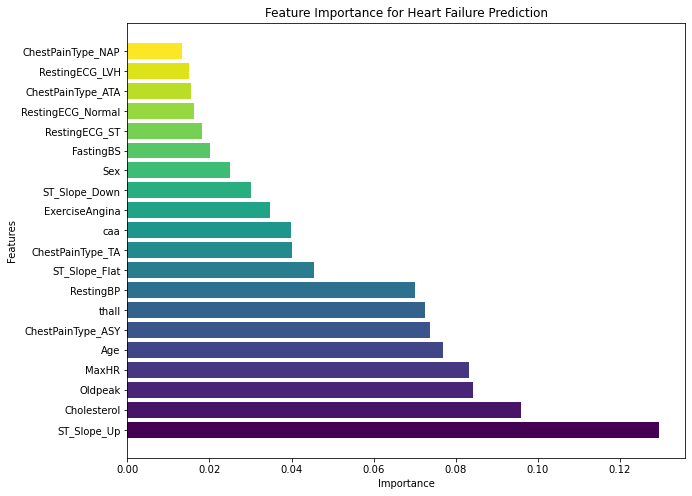

In [32]:
##Plot the correlaton between Features and Label
# Separate features and labels
X = df.drop('Label', axis=1)
y = df['Label']

# Initialize RandomForestClassifier (you may need to adjust parameters)
rf_model = RandomForestClassifier()
rf_model.fit(X, y)

# Get feature importances from the trained RF model
feature_importances = rf_model.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Define colors for each feature
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance_df)))

# Plot horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color=colors)
plt.title('Feature Importance for Heart Failure Prediction')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


In [9]:
# Load a dataset
X = df.drop('Label', axis=1)
y = df['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for Gradient Boosting
param_grid = {'n_estimators': [10, 25, 50, 100, 200], 'max_depth': [3, 5, 7]}

# Create Gradient Boosting model
model = GradientBoostingClassifier()  

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=6)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print('best_params', best_params)

# Train the model with the best hyperparameters
best_model = GradientBoostingClassifier(**best_params) 
best_model.fit(X_train, y_train)

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy GB: {accuracy * 100:.2f}%") 

best_params {'max_depth': 3, 'n_estimators': 50}
Accuracy GB: 88.98%


In [11]:
# Load a dataset
X = df.drop('Label', axis=1)
y = df['Label']
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Define hyperparameter grid
param_grid = {'n_estimators': [25,50, 100, 200], 'max_depth': [3, 5, 7,10]}
# Create XGBoost model
model = XGBClassifier()
# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=6)
grid_search.fit(X_train, y_train)
# Get the best hyperparameters
best_params = grid_search.best_params_
print('best_params',best_params)
# Train the model with the best hyperparameters
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)
# Make predictions using the best model
y_pred = best_model.predict(X_test)
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy XGB: {accuracy * 100:.2f}%")


best_params {'max_depth': 3, 'n_estimators': 25}
Accuracy XGB: 90.20%


In [12]:
# Load a dataset
X = df.drop('Label', axis=1)
y = df['Label']
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Define hyperparameter grid
param_grid = {'n_estimators': [10,25,50, 100, 200], 'max_depth': [3, 5, 7]}
# Create XGBoost model
model = RandomForestClassifier()
# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=6)
grid_search.fit(X_train, y_train)
# Get the best hyperparameters
best_params = grid_search.best_params_
print('best_params',best_params)
# Train the model with the best hyperparameters
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)
# Make predictions using the best model
y_pred = best_model.predict(X_test)
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy RF: {accuracy * 100:.2f}%")


best_params {'max_depth': 5, 'n_estimators': 50}
Accuracy RF: 88.16%


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Assuming 'Label' is the column containing the target variable
X = df.drop('Label', axis=1)
y = df['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create SVM model 
svm_model = SVC(C=10, kernel='linear', gamma='scale', probability=True)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions using the trained model
y_pred_svm = svm_model.predict(X_test)

# Evaluate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy(SVM): {accuracy_svm * 100:.2f}%")


Accuracy(SVM): 86.12%


In [39]:
##Meta Mode with (RF,GB,XGB,SVM)
# Load a dataset
X = df.drop('Label', axis=1)
y = df['Label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=5, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=25,max_depth=3)),
    ('svc', SVC(C=1.0, kernel='linear', gamma='scale', probability=True))

]

# Define a meta-model
meta_model = LogisticRegression()

# Stacking ensemble
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)
# Train stacked model
stacked_model.fit(X_train, y_train)

# Evaluate the model
print(f"Model Accuracy: {stacked_model.score(X_test, y_test) * 100:.2f}%")


Model Accuracy: 90.20%


In [18]:
##Meta Mode with (RF,XGB,SVC)
# Load a dataset
X = df.drop('Label', axis=1)
y = df['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=25,max_depth=3)),
    ('svc', SVC(C=1.0, kernel='linear', gamma='scale', probability=True))
]

# Define meta-model
meta_model = KNeighborsClassifier(n_neighbors=10)

# Stacking ensemble
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train stacked model
stacked_model.fit(X_train, y_train)

# Evaluate the model
accuracy = stacked_model.score(X_test, y_test)
print(f"Model Accuracy: {stacked_model.score(X_test, y_test) * 100:.2f}%")


Model Accuracy: 86.53%


In [167]:
##Meta Mode with (RF,GNB,DT) with logistic regression

# Load a dataset
X = df.drop('Label', axis=1)
y = df['Label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('gnb', GaussianNB()),  # Gaussian Naive Bayes
    ('dt', DecisionTreeClassifier(random_state=42))  # Decision Tree
]

# Define a meta-model
meta_model = LogisticRegression()

# Stacking ensemble
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train stacked model
stacked_model.fit(X_train, y_train)

# Evaluate the model
print(f"Model Accuracy: {stacked_model.score(X_test, y_test)* 100:.2f}%")


Model Accuracy: 0.8530612244897959
